# Compute pocket sizes
Plot distributions of pocket sizes for:
1. non-cryptic and cryptic pockets
2. successfully predicted pockets by each tool (p2rank, finetuned model, ...)

In [57]:
import sys
import numpy as np
import vis_utils
sys.path.append('/home/vit/Projects/cryptoshow-analysis/src/B-evaluate-cryptoshow')
sys.path.append('/home/vit/Projects/cryptoshow-analysis/src')
import eval_utils


In [58]:
CBS_DATA_PATH = '/home/vit/Projects/cryptoshow-analysis/data/A-cluster-ligysis-data/clustered-binding-sites.txt'
PREDICTIONS_PATH = '/home/vit/Projects/cryptoshow-analysis/data/D-visualize/predictions'

# load ground truth binding residues: these have mmcif numbering and need to be mapped to auth labeling
cryptic_binding_residues_mmcifed, _ = eval_utils.read_test_binding_residues(data_path=CBS_DATA_PATH)
cryptic_binding_residues_mmcifed = vis_utils.reformat_binding_residues(cryptic_binding_residues_mmcifed)
non_cryptic_binding_residues_mmcifed, _ = eval_utils.read_test_binding_residues(data_path=CBS_DATA_PATH, pocket_types=['NON_CRYPTIC'])
non_cryptic_binding_residues_mmcifed = vis_utils.reformat_binding_residues(non_cryptic_binding_residues_mmcifed)

# load predictions
p2rank_predictions_mmcifed = vis_utils.read_predictions(data_path=f'{PREDICTIONS_PATH}/p2rank', protein_ids=cryptic_binding_residues_mmcifed.keys())
model_predictions_mmcifed = vis_utils.read_predictions(data_path=f'{PREDICTIONS_PATH}/finetuning-with-smoothing', protein_ids=cryptic_binding_residues_mmcifed.keys())

## Plot dataset sizes
Plot distribution of pocket sizes for noncryptic and cryptic pockets.

In [59]:
all_cryptic_pockets = []
all_non_cryptic_pockets = []
for protein_id in cryptic_binding_residues_mmcifed.keys():
    all_cryptic_pockets.extend(cryptic_binding_residues_mmcifed[protein_id])
    if protein_id in non_cryptic_binding_residues_mmcifed:
        all_non_cryptic_pockets.extend(non_cryptic_binding_residues_mmcifed[protein_id])


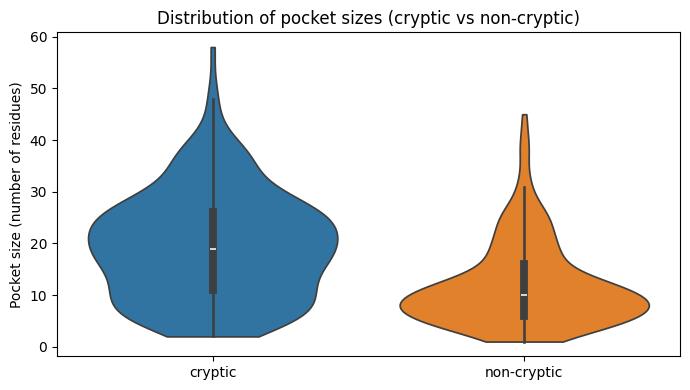

In [60]:
import seaborn as sns
import matplotlib.pyplot as plt

sizes_cryptic = [len(i) for i in all_cryptic_pockets]
sizes_non_cryptic = [len(i) for i in all_non_cryptic_pockets]

plt.figure(figsize=(7, 4))
sns.violinplot(data=[sizes_cryptic, sizes_non_cryptic], inner='box', cut=0)
plt.xticks([0, 1], ['cryptic', 'non-cryptic'])
plt.ylabel('Pocket size (number of residues)')
plt.title('Distribution of pocket sizes (cryptic vs non-cryptic)')
plt.tight_layout()
plt.show()

## plot P2Rank
Plot sizes of pockets, which were successfuly predicted by P2Rank (DCC < 4A).

In [61]:
COORDINATES_DIR = '/home/vit/Projects/cryptoshow-analysis/data/A-cluster-ligysis-data/coordinates'

def compute_avg_successful_pocket_size(binding_pockets, predicted_pockets):
    avg_success_pocket_size = []
    for protein_id in binding_pockets.keys(): 
        this_binding_residues = binding_pockets[protein_id]
        this_p2rank_predictions = predicted_pockets[protein_id]
        sys.path.append('/home/skrhakv/cryptoshow-analysis/src')
        sys.path.append('/home/vit/Projects/cryptoshow-analysis/src')
        import cryptoshow_utils


        for true_pocket in this_binding_residues:
            dcc = float('inf')
            coordinates = np.load(f'{COORDINATES_DIR}/{protein_id.replace("_", "")}.npy')
            for predicted_pocket in this_p2rank_predictions:
                this_dcc = cryptoshow_utils.compute_center_distance(coordinates, true_pocket, predicted_pocket)
                dcc = min(dcc, this_dcc)
            if dcc < 4.0:
                avg_success_pocket_size.append(len(true_pocket))
    
    return avg_success_pocket_size

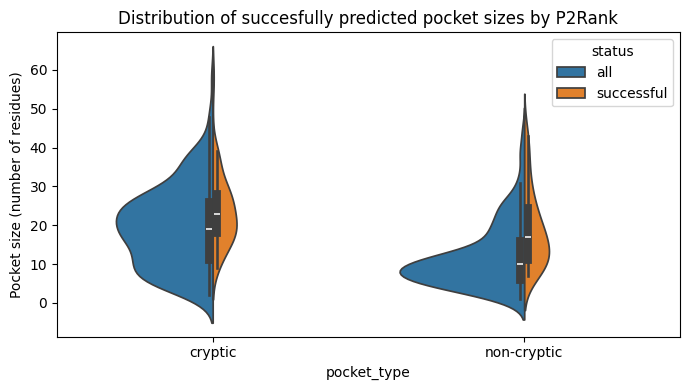

In [89]:
successful_cryptic_predictions = compute_avg_successful_pocket_size(cryptic_binding_residues_mmcifed, p2rank_predictions_mmcifed)
successful_non_cryptic_predictions = compute_avg_successful_pocket_size(non_cryptic_binding_residues_mmcifed, p2rank_predictions_mmcifed)
import pandas as pd

df = pd.DataFrame({     
    'size': sizes_cryptic + sizes_non_cryptic + successful_cryptic_predictions + successful_non_cryptic_predictions,
    'pocket_type': (['cryptic'] * len(sizes_cryptic) +
                    ['non-cryptic'] * len(sizes_non_cryptic) +
                    ['cryptic'] * len(successful_cryptic_predictions) +
                    ['non-cryptic'] * len(successful_non_cryptic_predictions)),
    'status': (['all'] * (len(sizes_cryptic) + len(sizes_non_cryptic)) +
               ['successful'] * (len(successful_cryptic_predictions) + len(successful_non_cryptic_predictions)))
})
plt.figure(figsize=(7, 4))
ax = sns.violinplot(data=df, x='pocket_type', y='size', hue='status', split=True, density_norm="count" , common_norm=True)
plt.xticks([0, 1], ['cryptic', 'non-cryptic'])
plt.ylabel('Pocket size (number of residues)')
plt.title("Distribution of succesfully predicted pocket sizes by P2Rank")
plt.tight_layout()
plt.show()

In [85]:
# total successful predictions
successful_total = (df['status'] == 'successful').sum()
print('total successful predictions:', successful_total)

# successful predictions per pocket type
print('successful per pocket_type:')
print(df[df['status'] == 'successful'].groupby('pocket_type').size())

# total successful predictions
successful_total = (df['status'] == 'all').sum()
print('total successful predictions:', successful_total)

# successful predictions per pocket type
print('successful per pocket_type:')
print(df[df['status'] == 'all'].groupby('pocket_type').size())

total successful predictions: 108
successful per pocket_type:
pocket_type
cryptic        53
non-cryptic    55
dtype: int64
total successful predictions: 492
successful per pocket_type:
pocket_type
cryptic        215
non-cryptic    277
dtype: int64
